# Strategy V4.3

---

### Generating Price Data and Integrating Trend Lines

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Series, DataFrame 
from numpy import ndarray
from typing import Dict, Tuple, List

In [77]:
def get_instruments() -> Dict[int, DataFrame]:
	raw_prices: DataFrame = pd.read_csv("../../prices.txt", sep=r"\s+", index_col=None,
		header=None)
	price_history: ndarray = raw_prices.values[:550][:].T

	data: Dict[int, DataFrame] = {}
	for instrument_no in range(0, 50):
		data[instrument_no] = pd.DataFrame(columns=["price"])
		weekly_prices: List[int] = []
		for i in range(0, 550, 10):
			weekly_prices.append(price_history[instrument_no][i])
		data[instrument_no]["price"] = np.array(weekly_prices) 

	return data

def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
	# compute sum of differences between line and prices, 
	# return negative val if invalid 

	# Find the intercept of the line going through pivot point with given slope
	intercept = -slope * pivot + y[pivot]
	line_vals = slope * np.arange(len(y)) + intercept

	diffs = line_vals - y

	# Check to see if the line is valid, return -1 if it is not valid.
	if support and diffs.max() > 1e-5:
		return -1.0
	elif not support and diffs.min() < -1e-5:
		return -1.0

	# Squared sum of diffs between data and line 
	err = (diffs ** 2.0).sum()
	return err;


def optimize_slope(support: bool, pivot:int , init_slope: float, y: np.array):

	# Amount to change slope by. Multiplyed by opt_step
	slope_unit = (y.max() - y.min()) / len(y)

	# Optmization variables
	opt_step = 1.0
	min_step = 0.0001
	curr_step = opt_step # current step

	# Initiate at the slope of the line of best fit
	best_slope = init_slope
	best_err = check_trend_line(support, pivot, init_slope, y)
	assert(best_err >= 0.0) # Shouldn't ever fail with initial slope

	get_derivative = True
	derivative = None
	while curr_step > min_step:

		if get_derivative:
			# Numerical differentiation, increase slope by very small amount
			# to see if error increases/decreases. 
			# Gives us the direction to change slope.
			slope_change = best_slope + slope_unit * min_step
			test_err = check_trend_line(support, pivot, slope_change, y)
			derivative = test_err - best_err;

			# If increasing by a small amount fails, 
			# try decreasing by a small amount
			if test_err < 0.0:
				slope_change = best_slope - slope_unit * min_step
				test_err = check_trend_line(support, pivot, slope_change, y)
				derivative = best_err - test_err

			if test_err < 0.0: # Derivative failed, give up
				raise Exception("Derivative failed. Check your data. ")

			get_derivative = False

		if derivative > 0.0: # Increasing slope increased error
			test_slope = best_slope - slope_unit * curr_step
		else: # Increasing slope decreased error
			test_slope = best_slope + slope_unit * curr_step


		test_err = check_trend_line(support, pivot, test_slope, y)
		if test_err < 0 or test_err >= best_err:
			# slope failed/didn't reduce error
			curr_step *= 0.5 # Reduce step size
		else: # test slope reduced error
			best_err = test_err
			best_slope = test_slope
			get_derivative = True # Recompute derivative

	# Optimize done, return best slope and intercept
	return (best_slope, -best_slope * pivot + y[pivot])


def fit_trendlines_single(data: np.array):
	# find line of best fit (least squared) 
	# coefs[0] = slope,  coefs[1] = intercept 
	x = np.arange(len(data))
	coefs = np.polyfit(x, data, 1)

	# Get points of line.
	line_points = coefs[0] * x + coefs[1]

	# Find upper and lower pivot points
	upper_pivot = (data - line_points).argmax()
	lower_pivot = (data - line_points).argmin()

	# Optimize the slope for both trend lines
	support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
	resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

	return (support_coefs, resist_coefs)

### Trendline Breakout Strategy

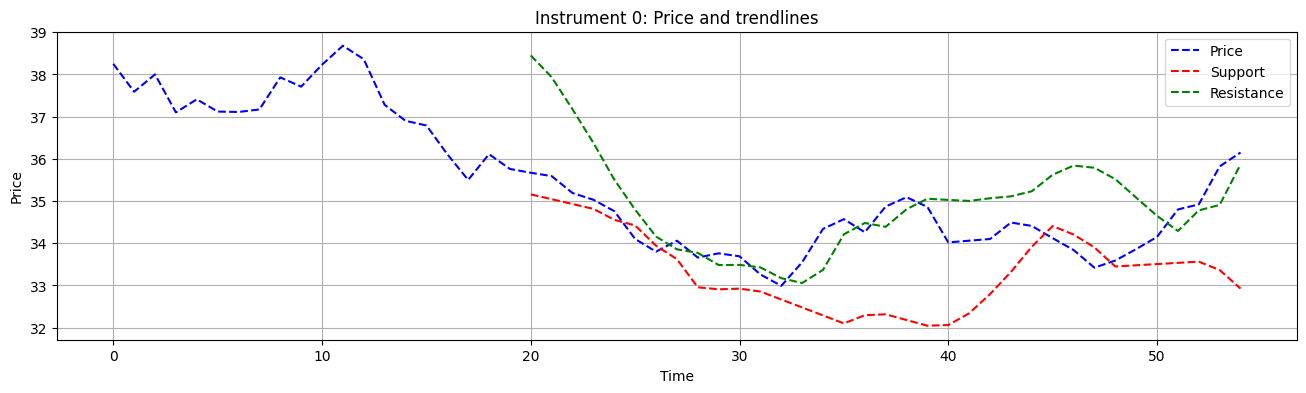

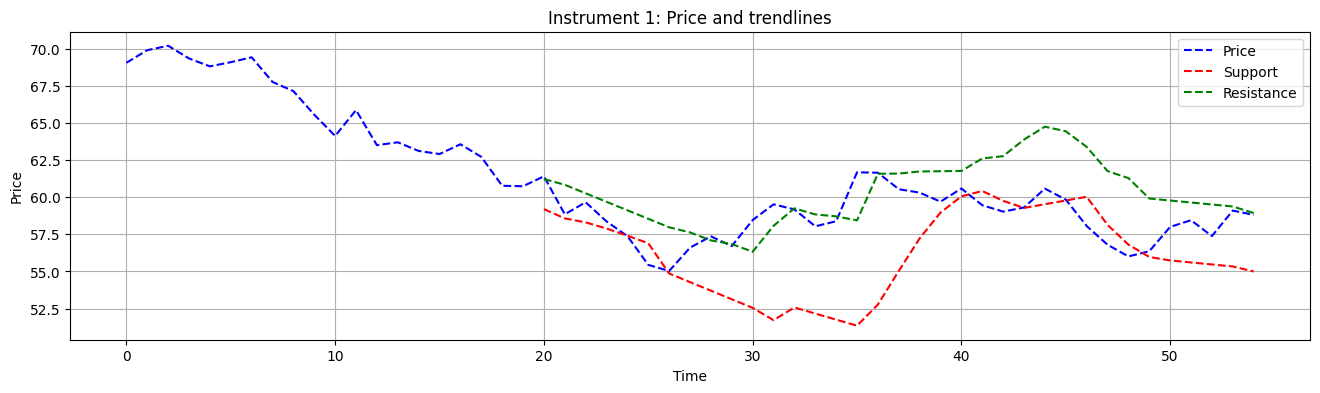

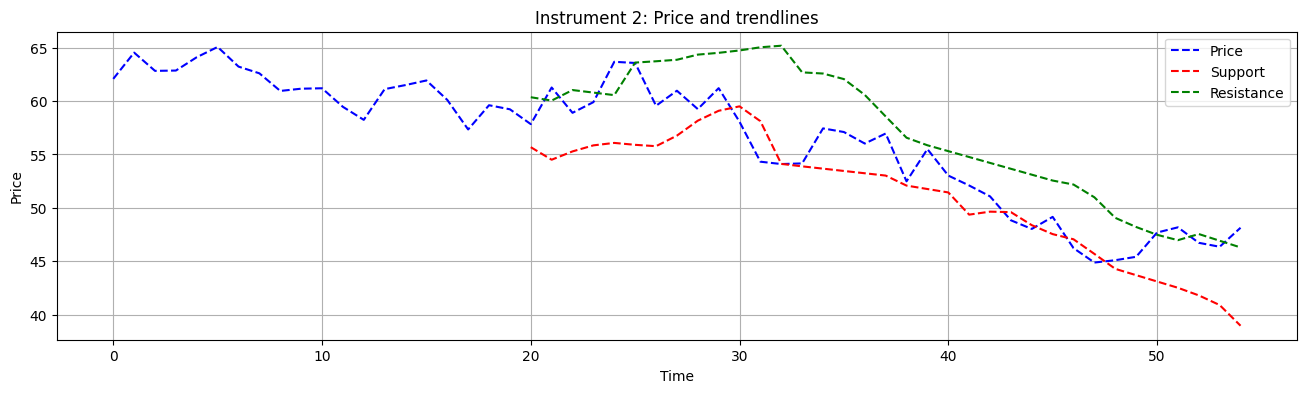

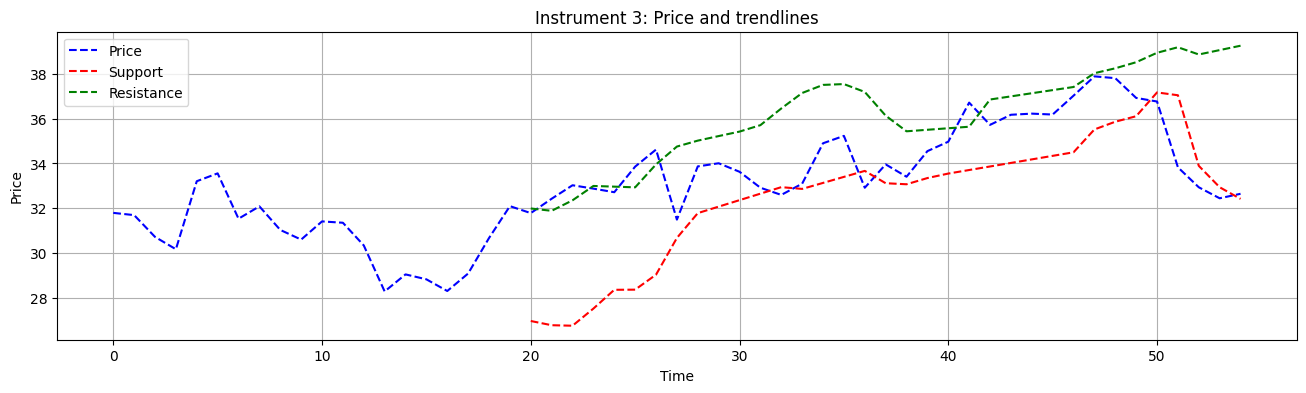

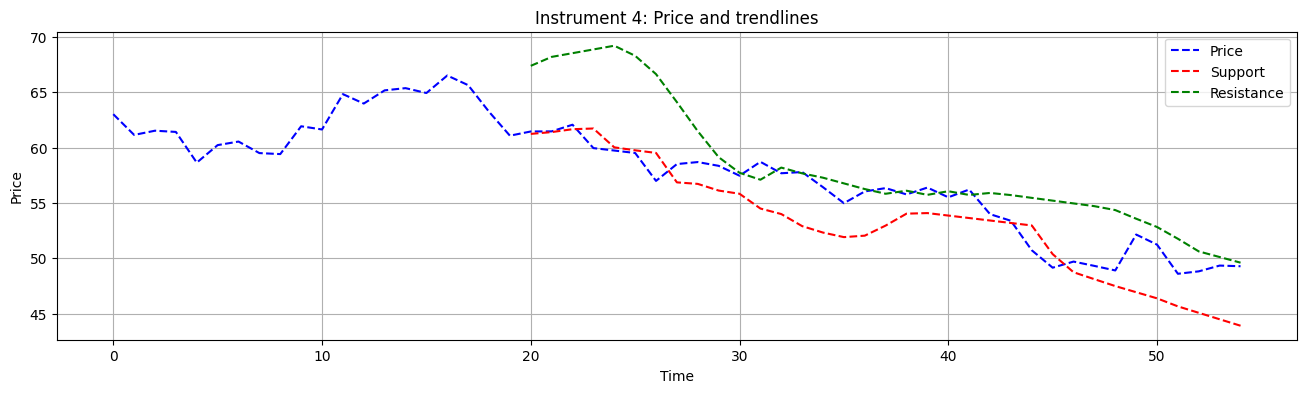

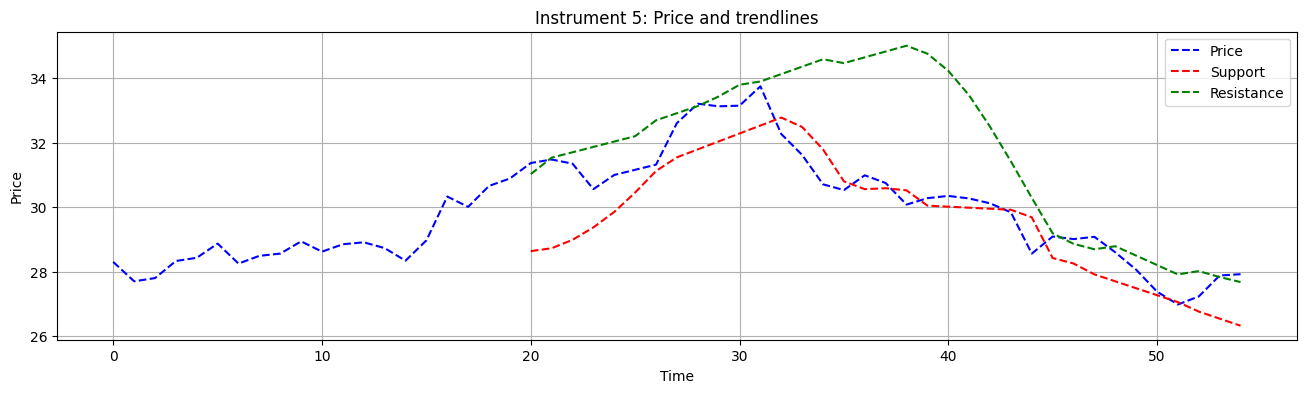

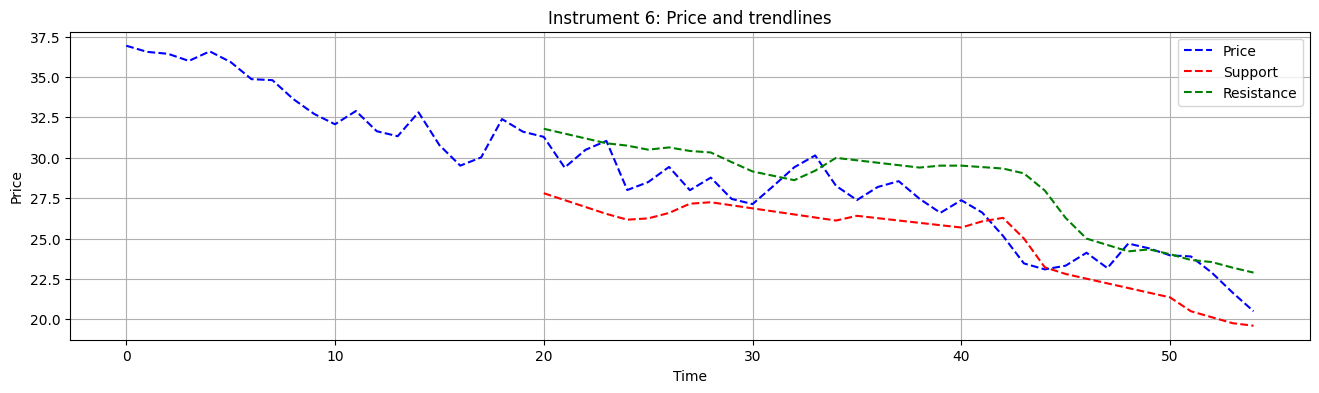

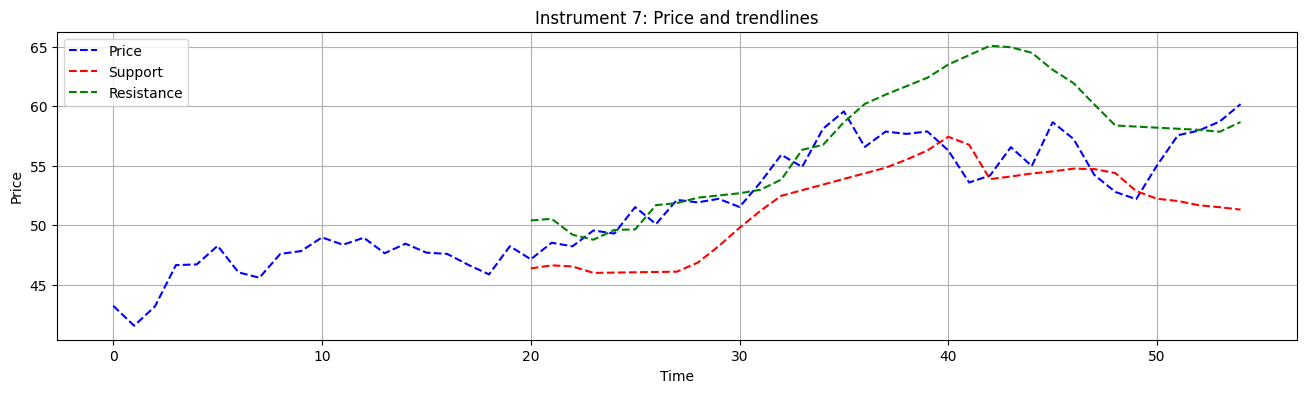

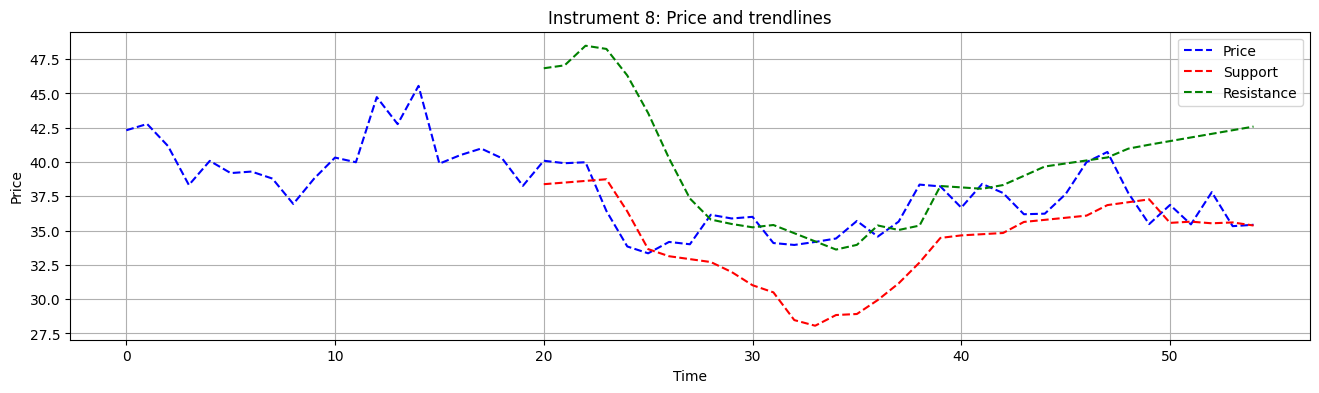

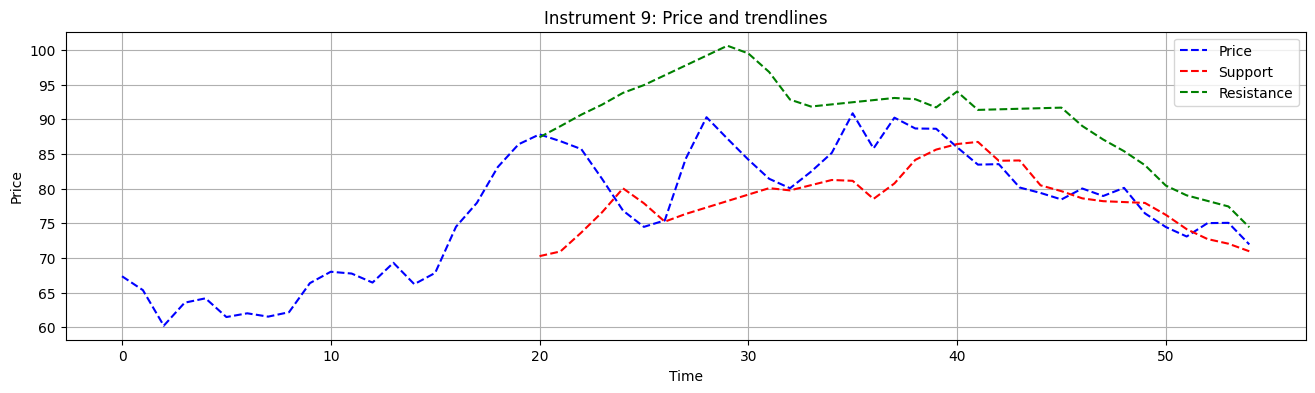

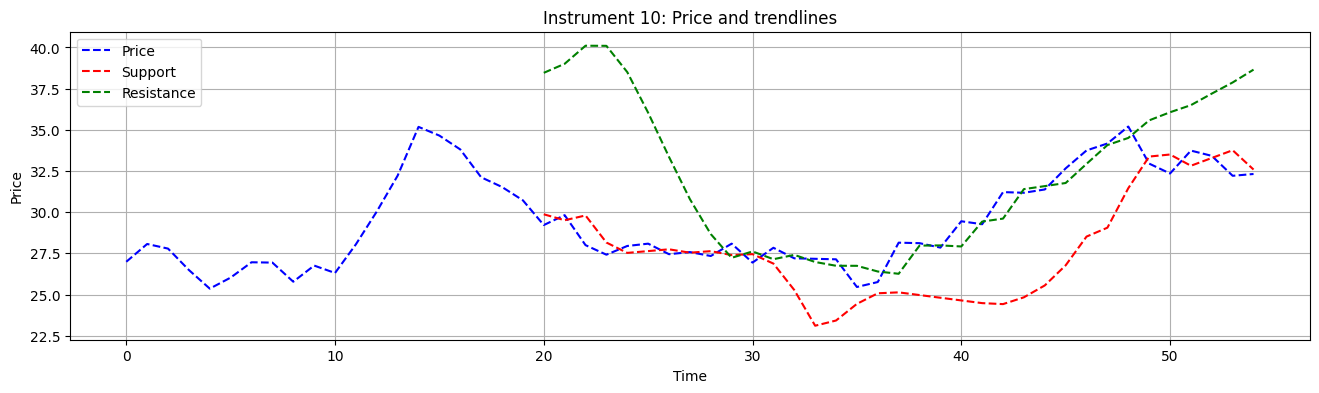

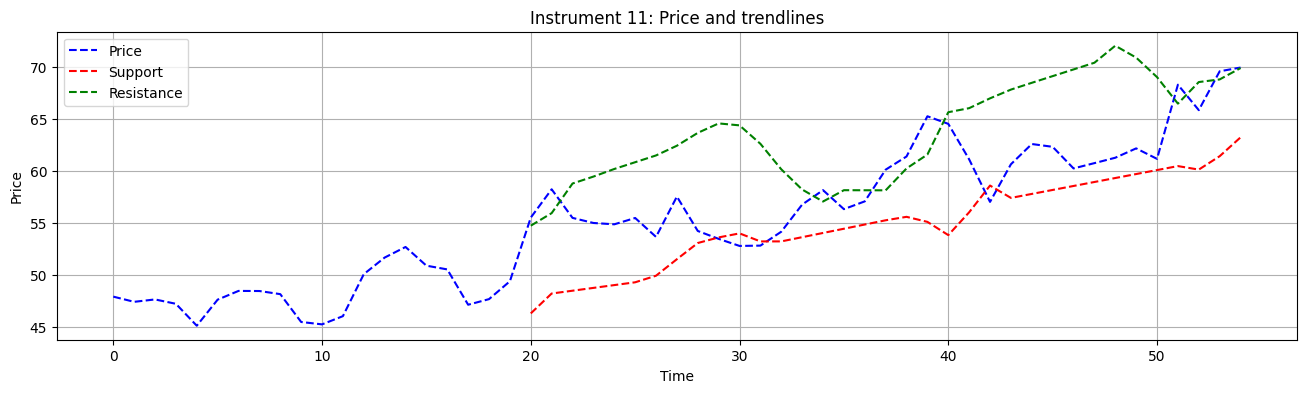

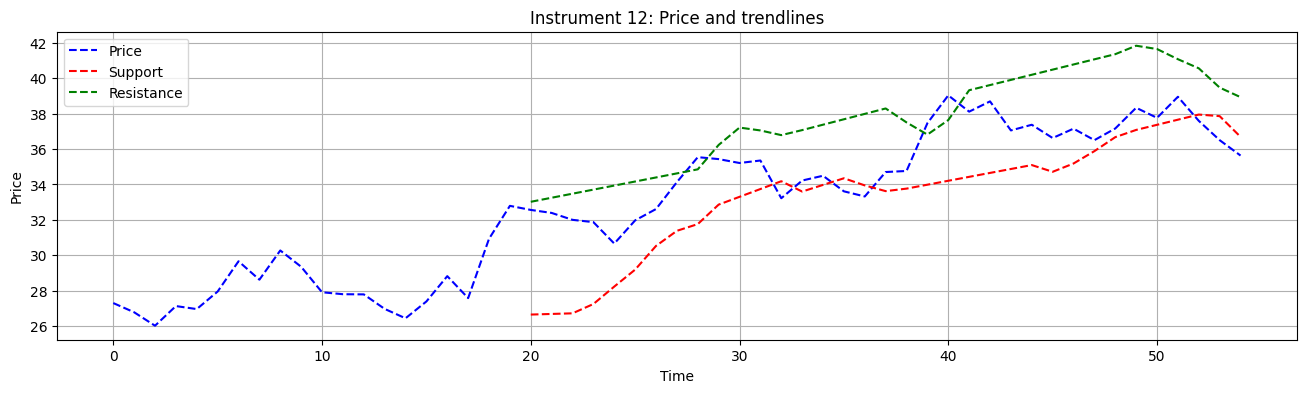

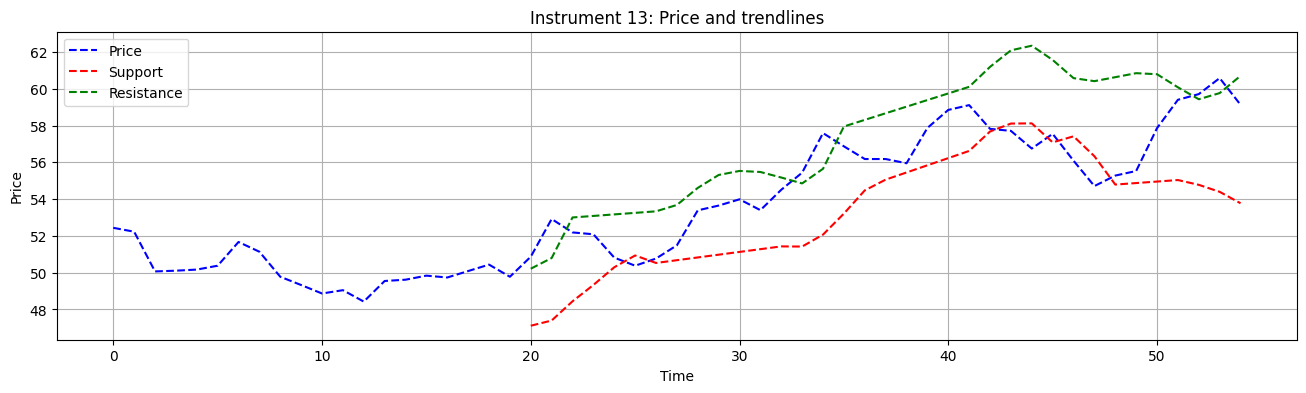

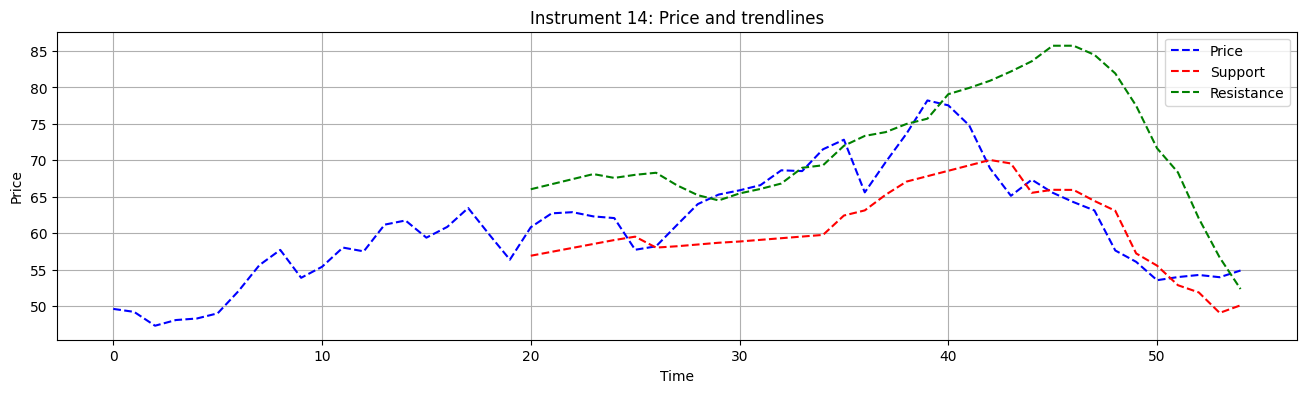

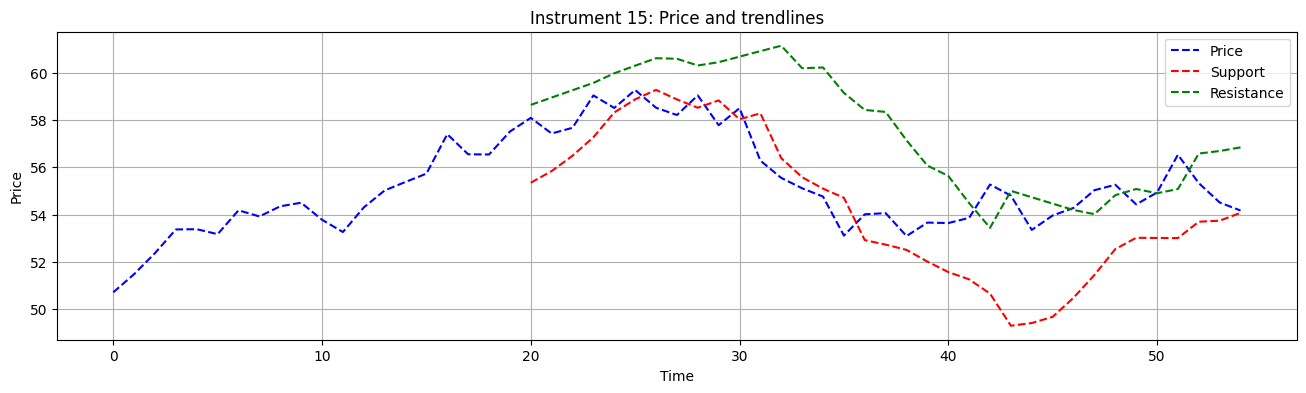

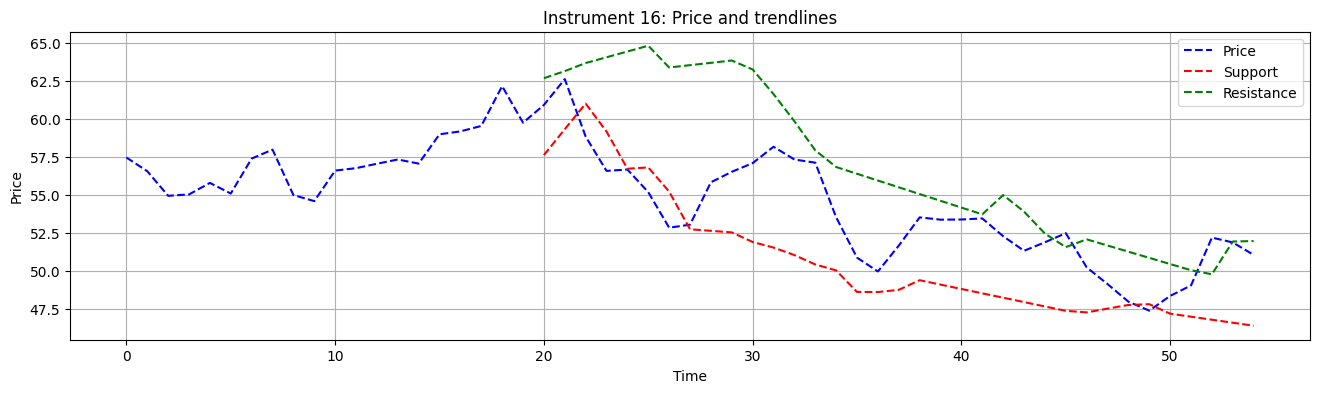

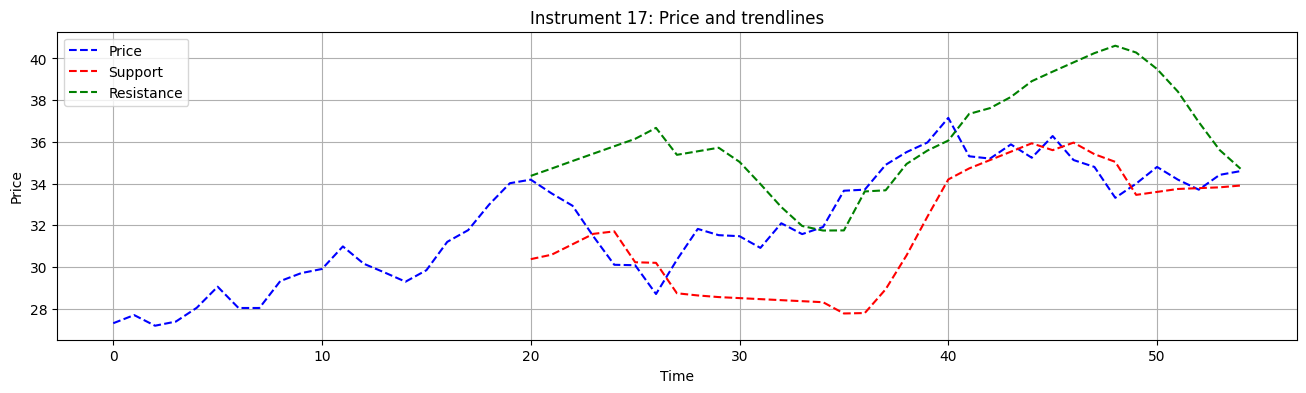

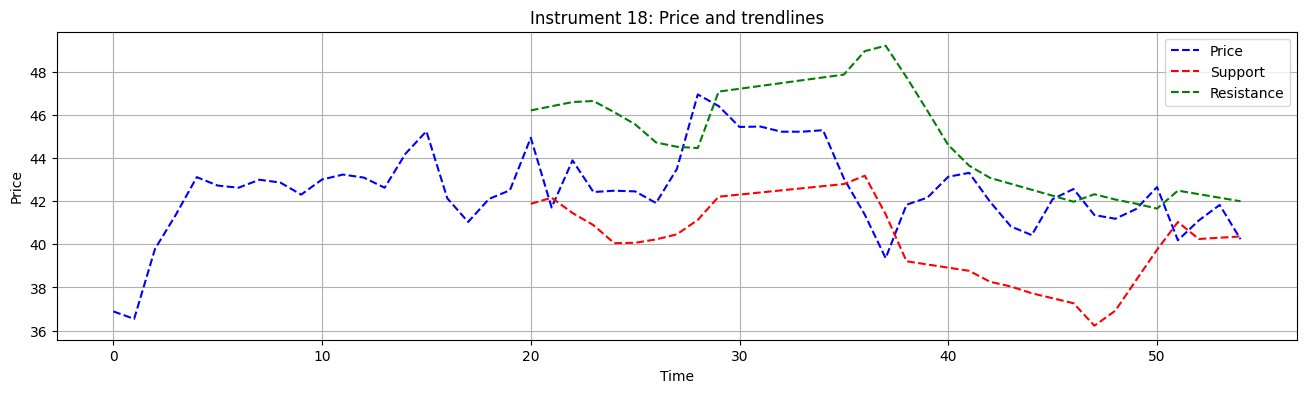

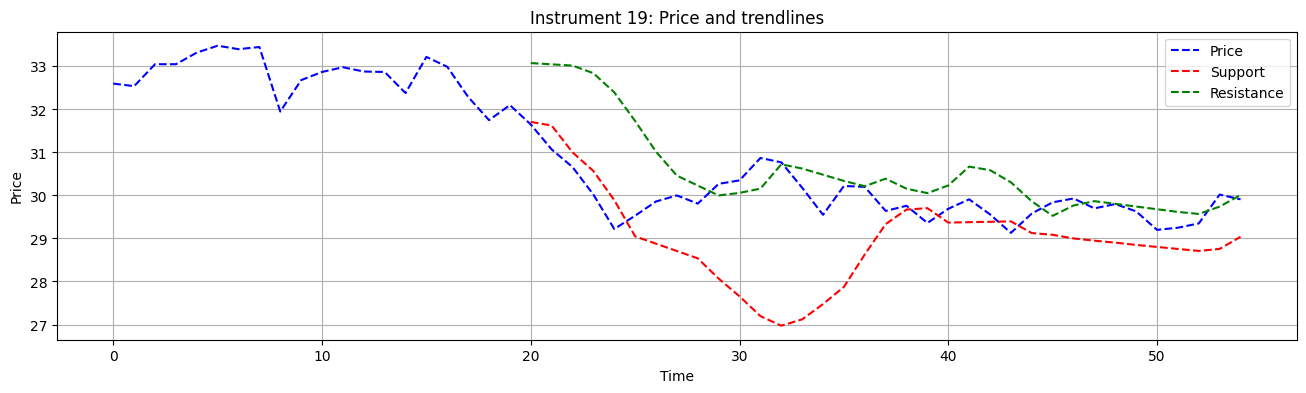

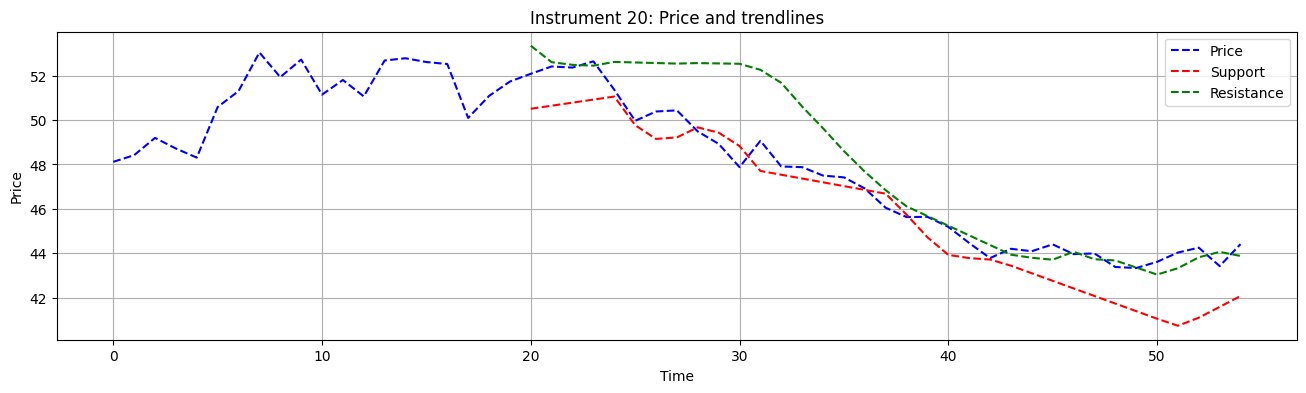

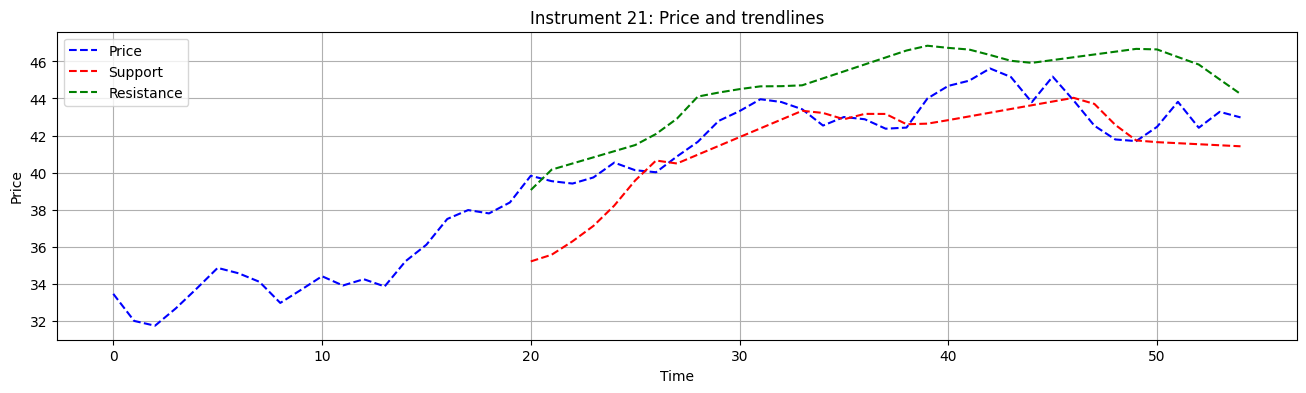

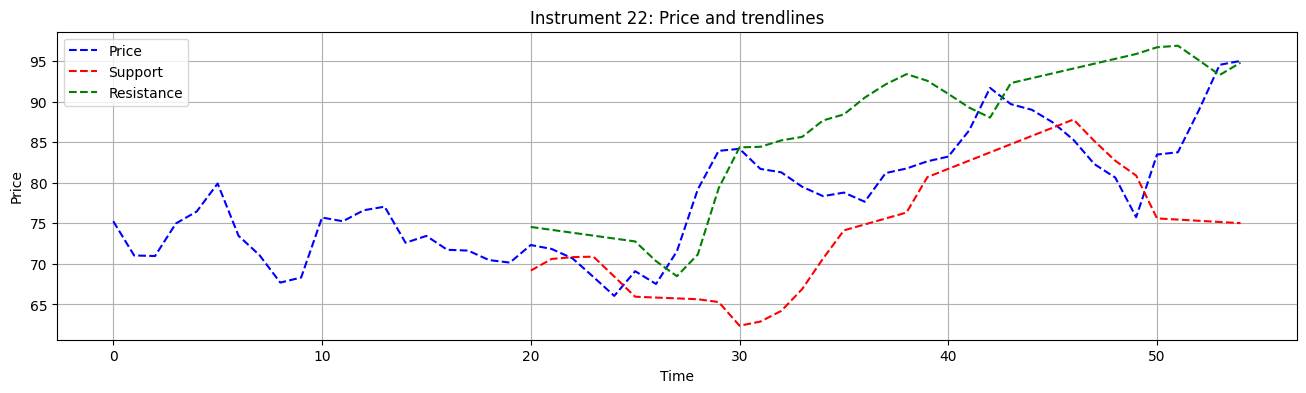

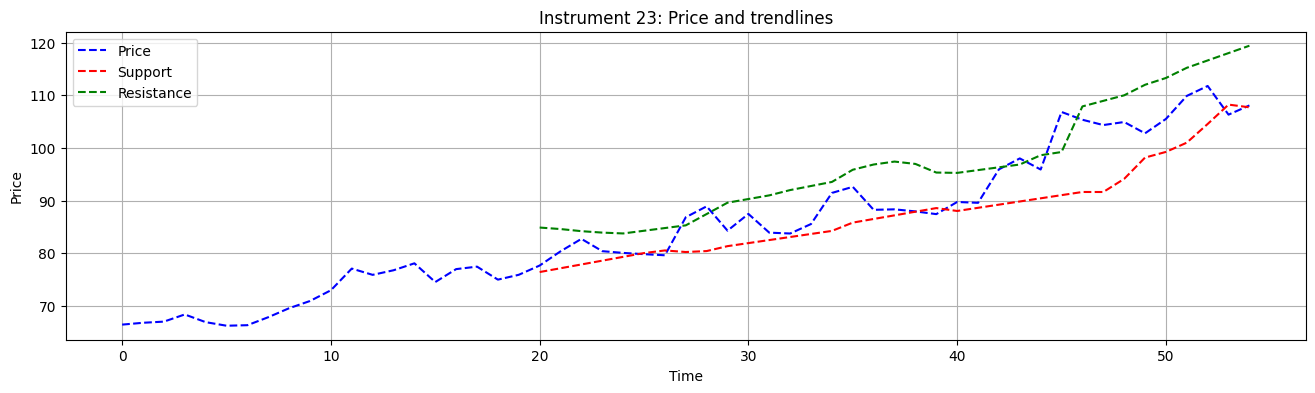

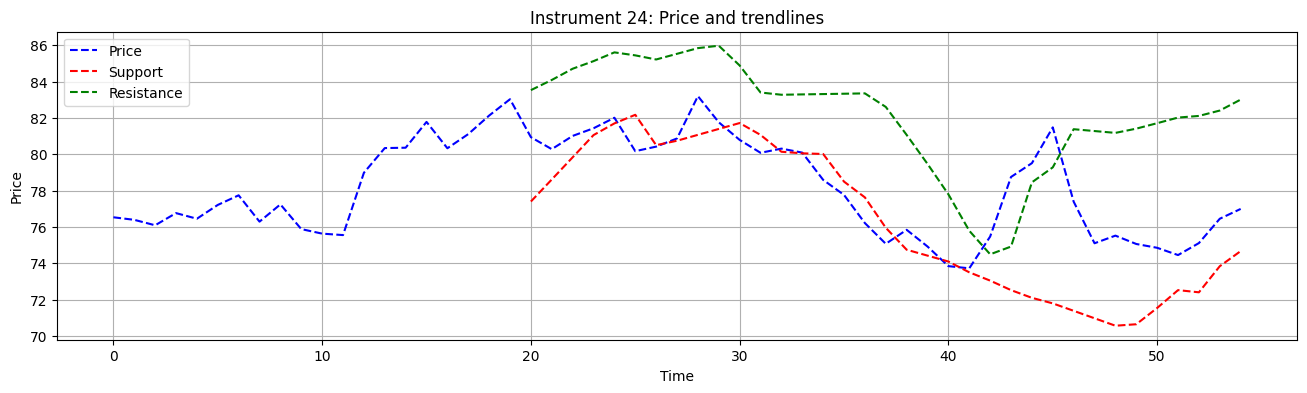

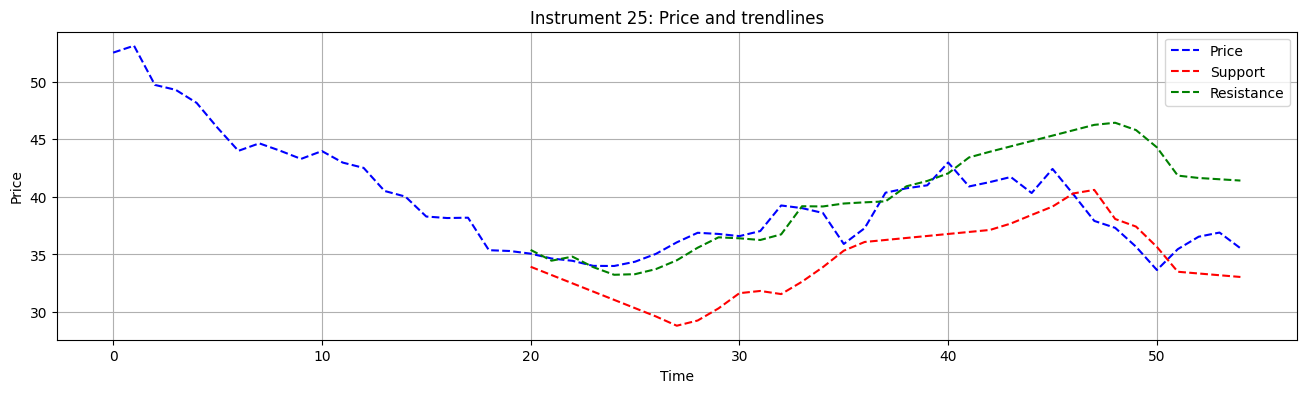

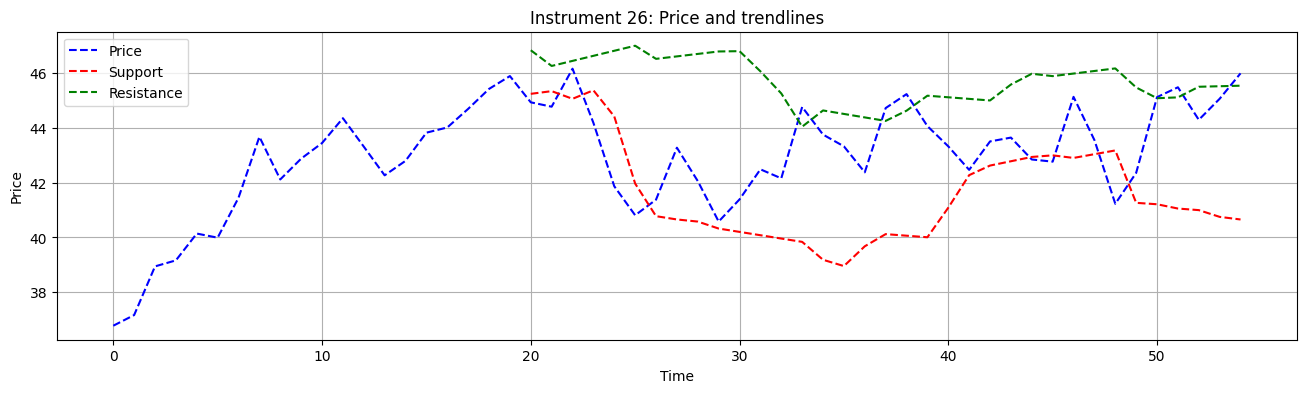

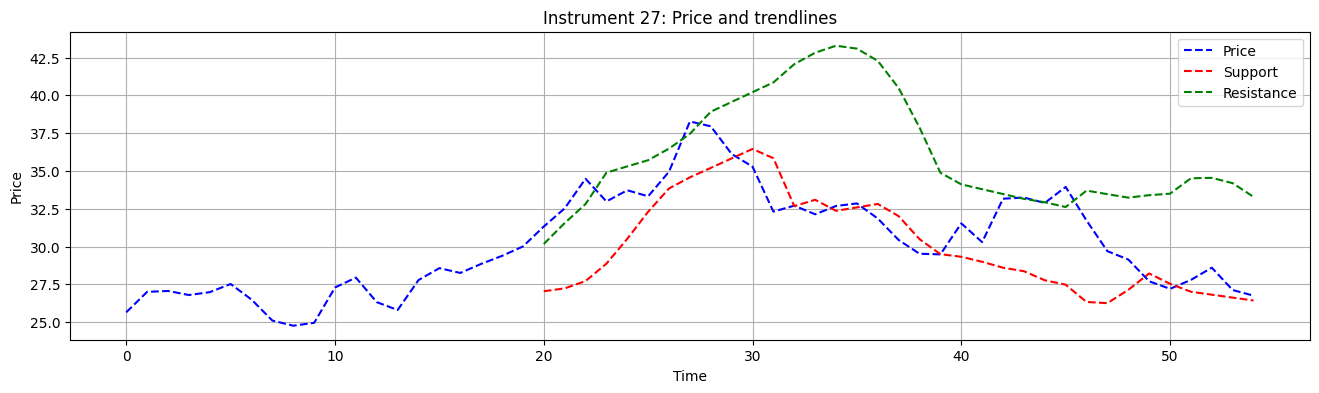

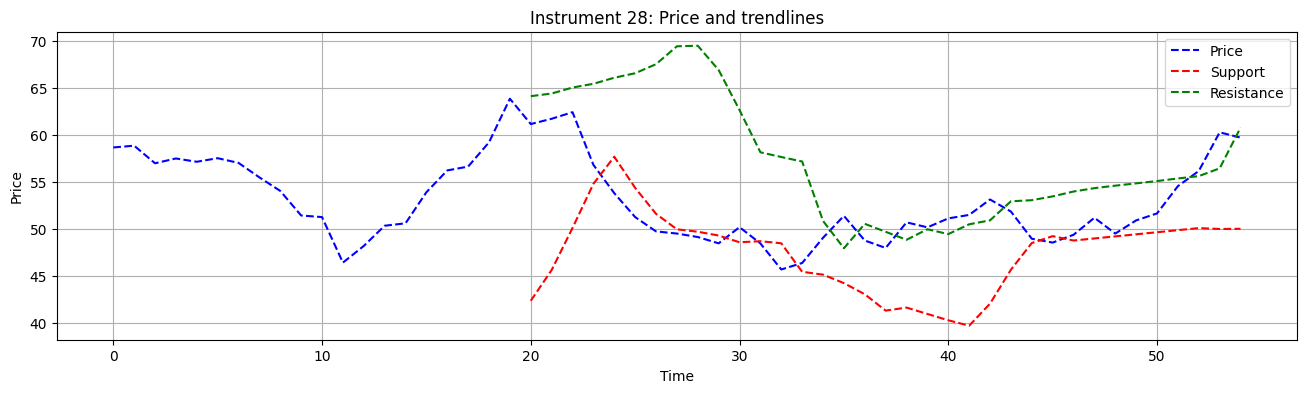

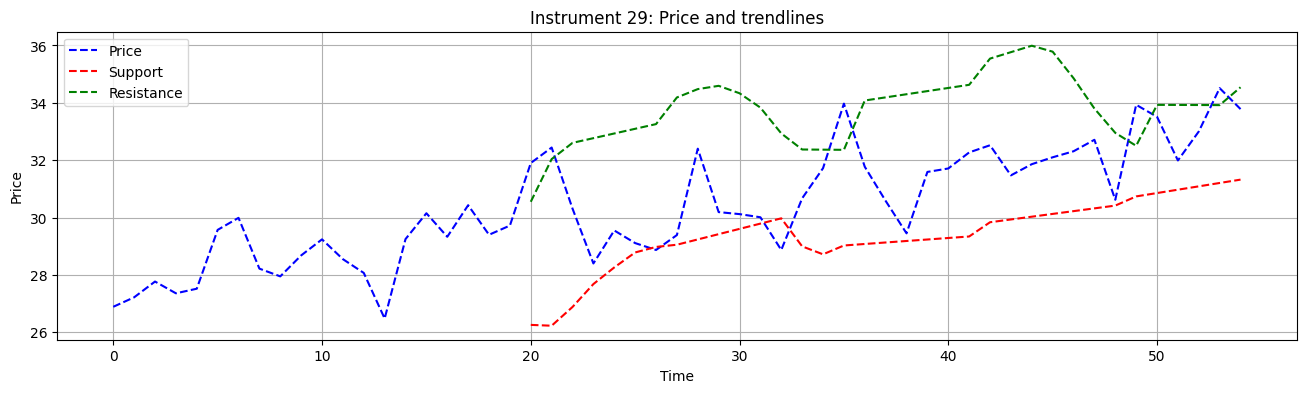

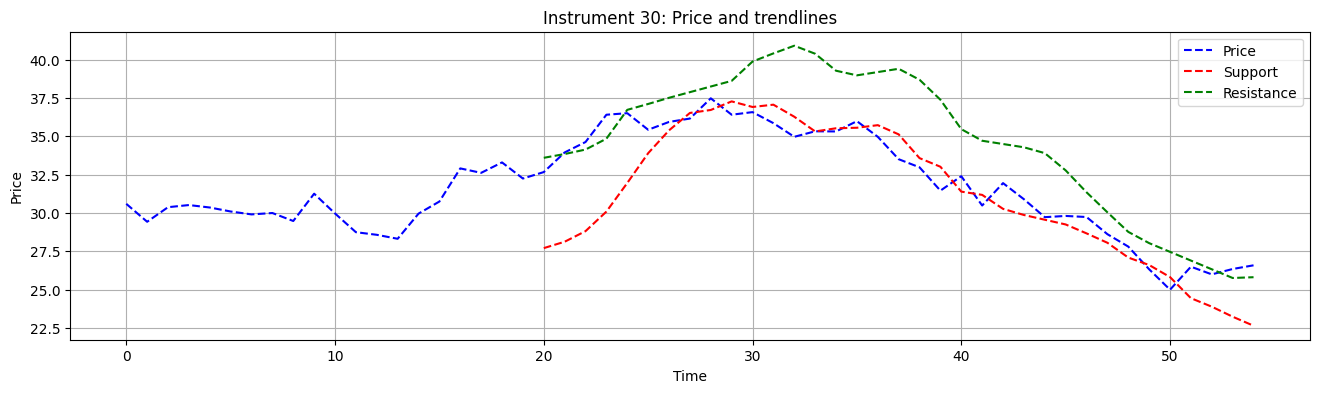

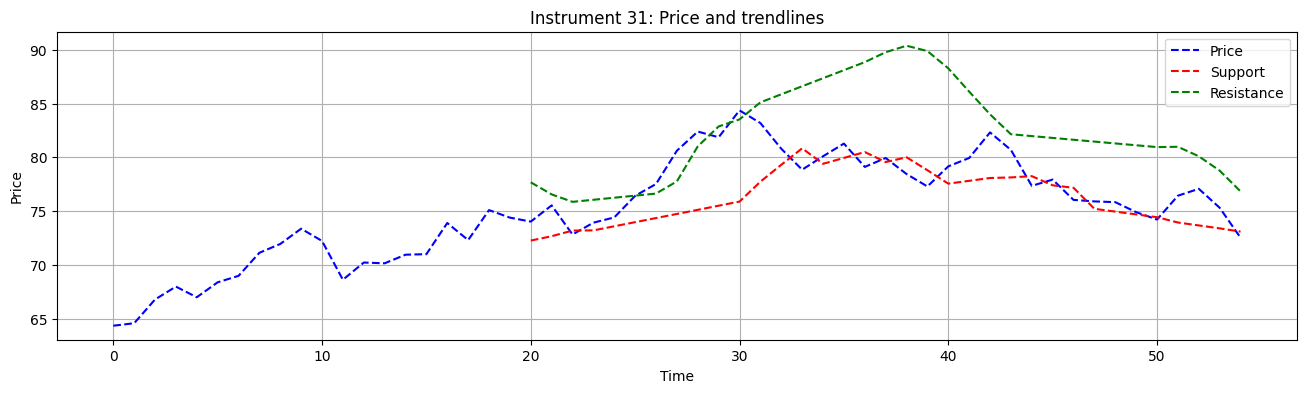

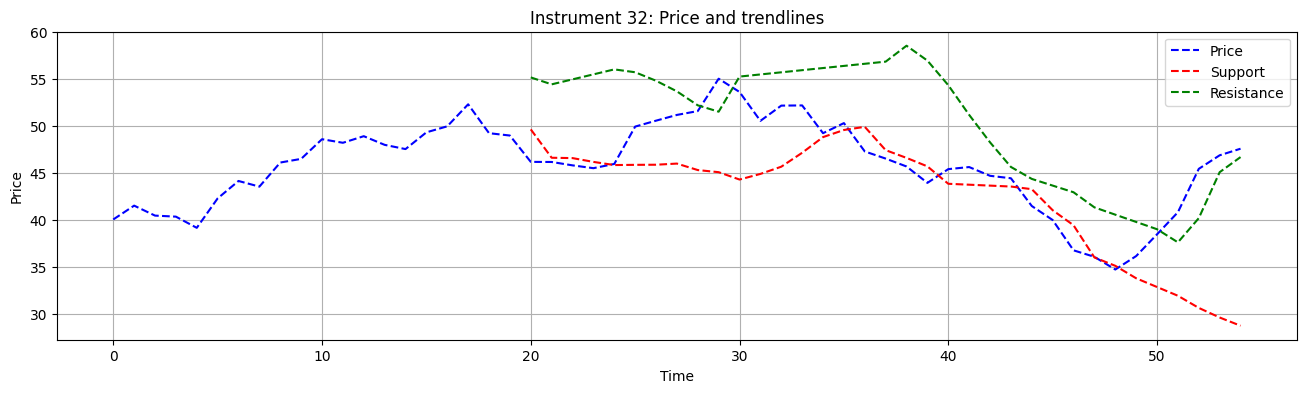

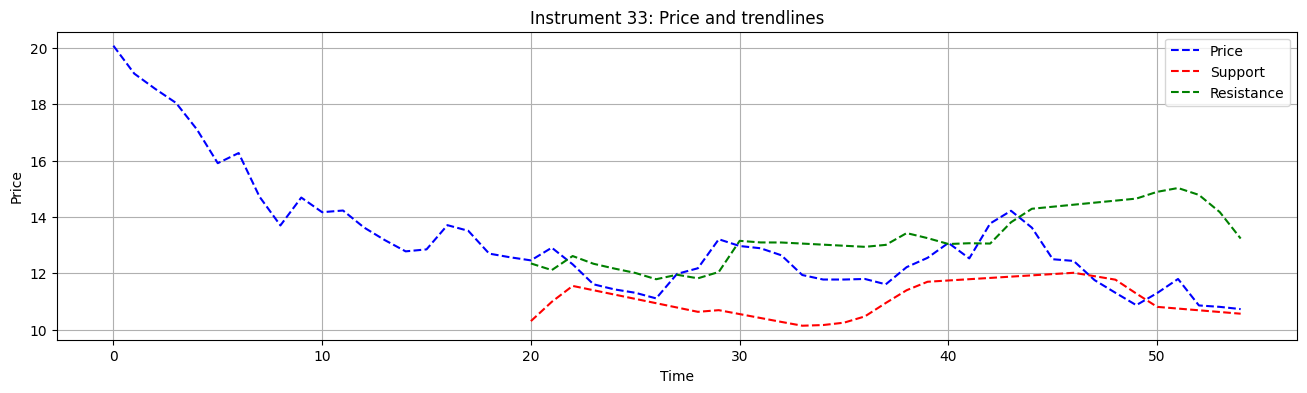

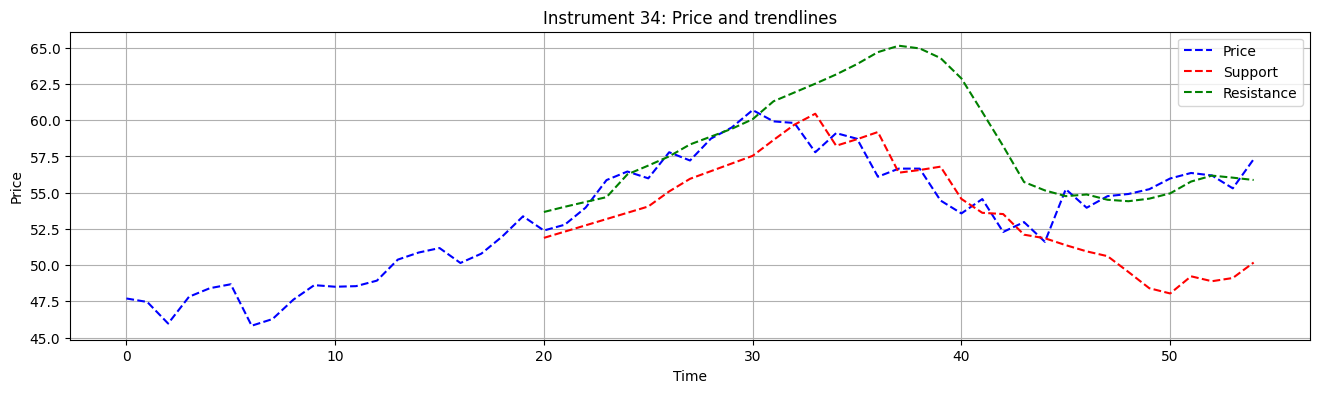

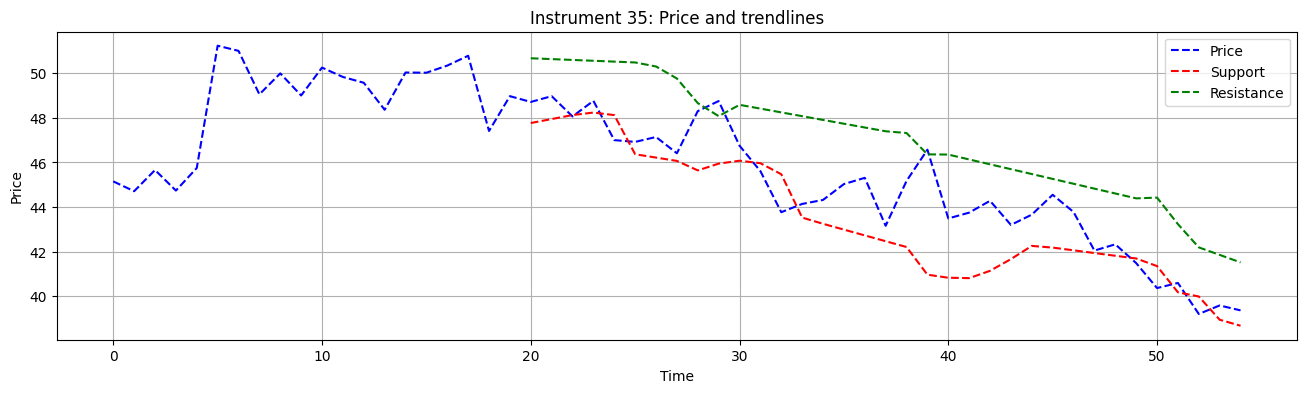

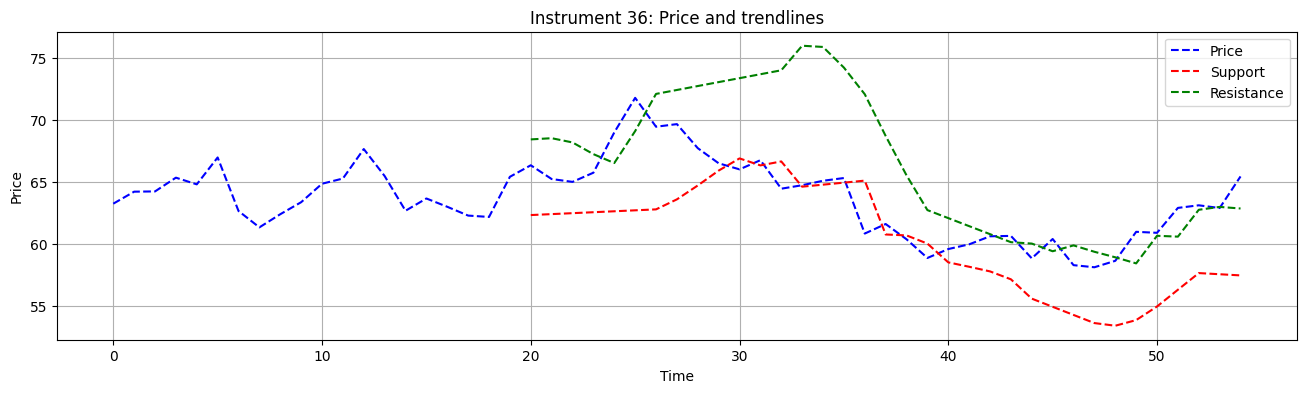

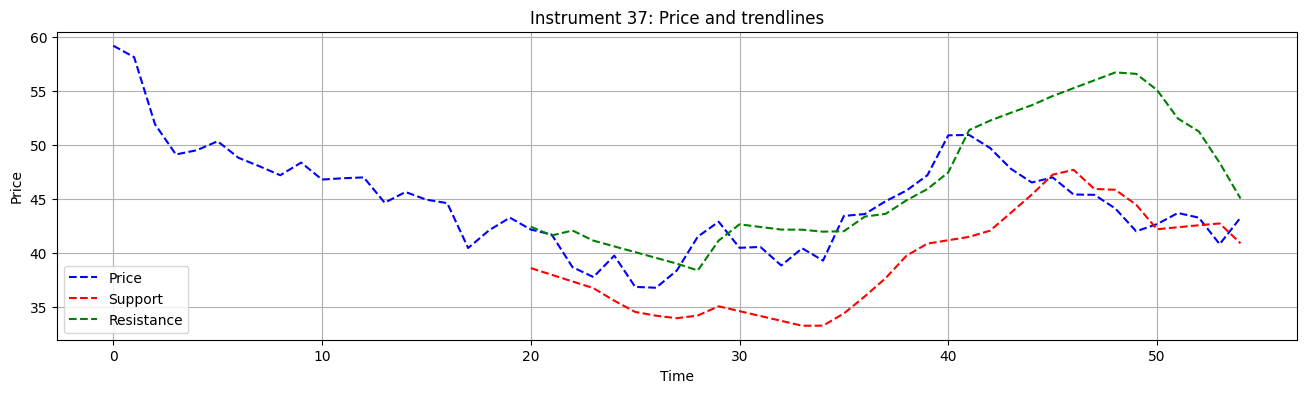

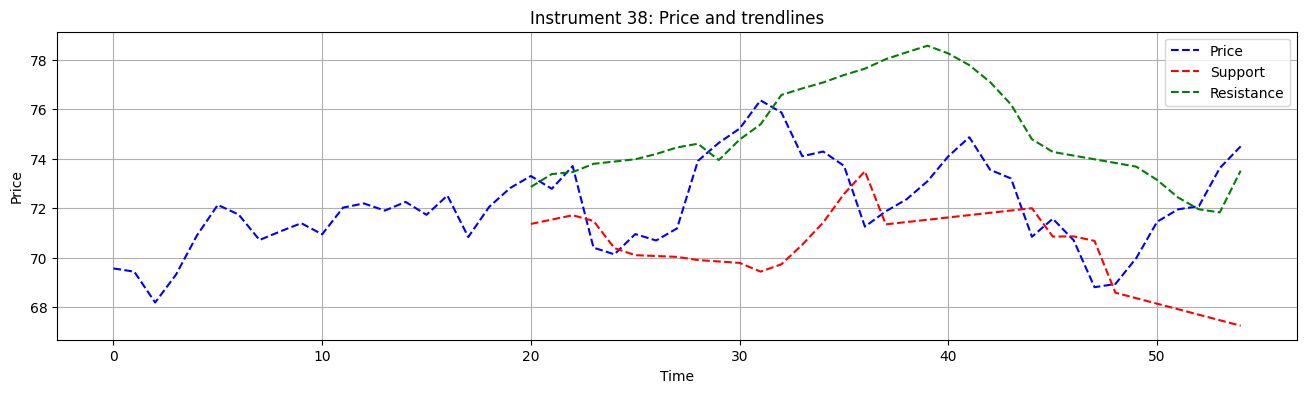

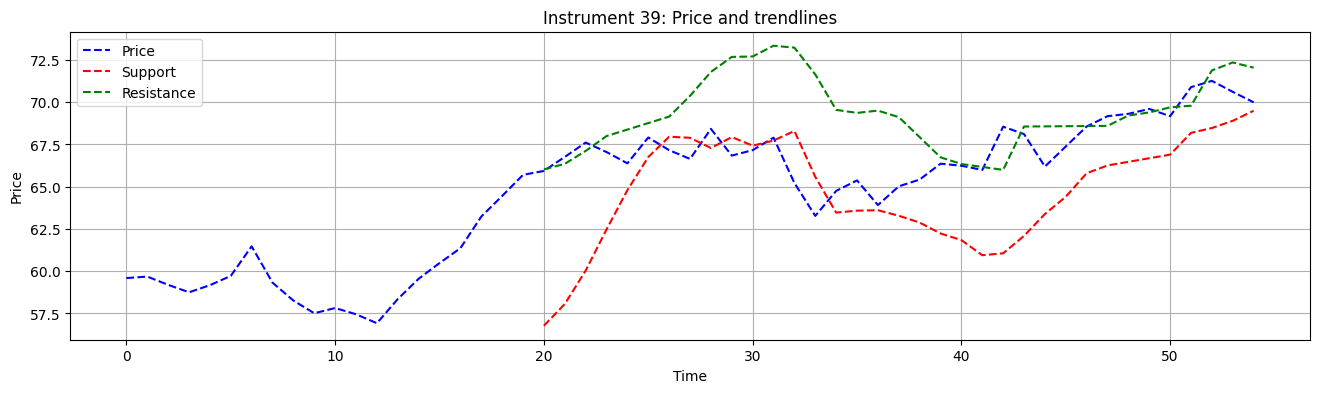

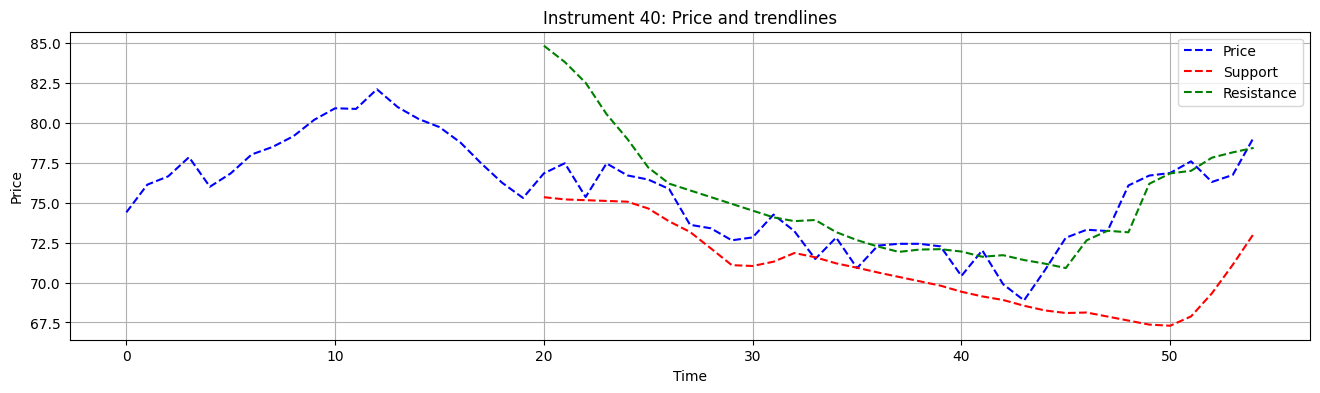

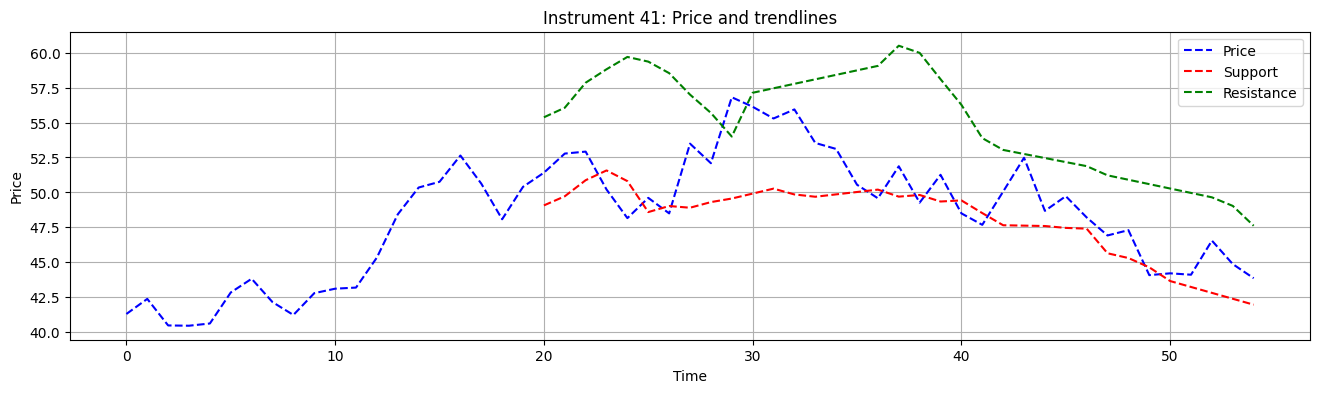

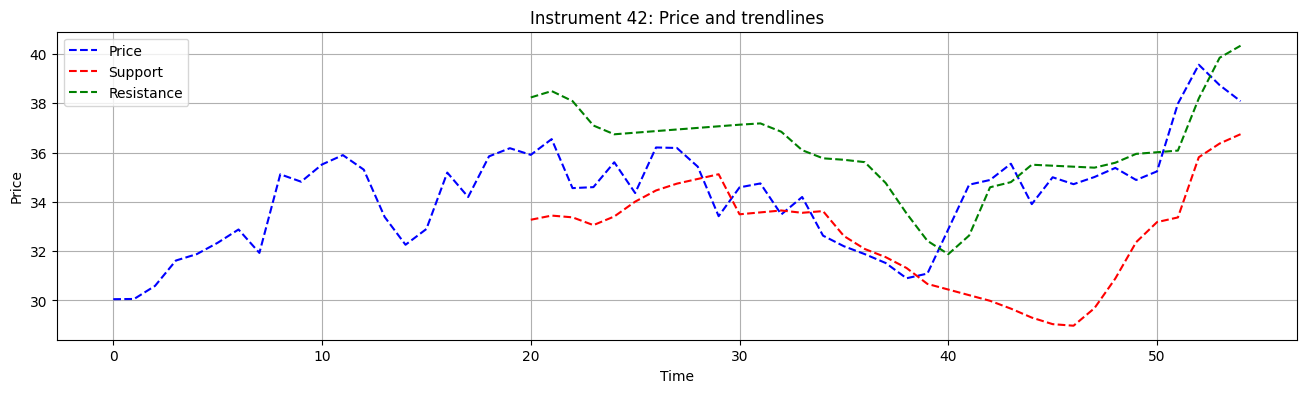

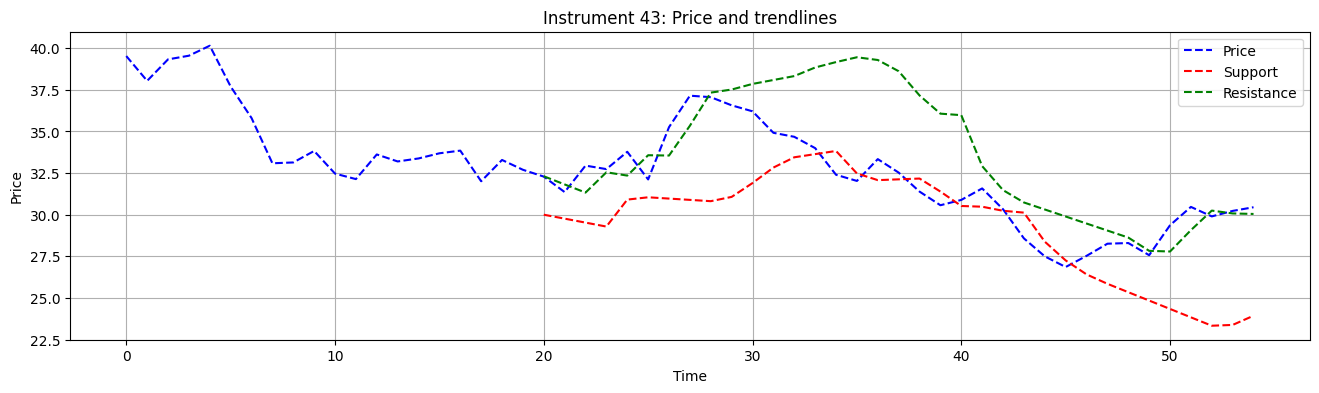

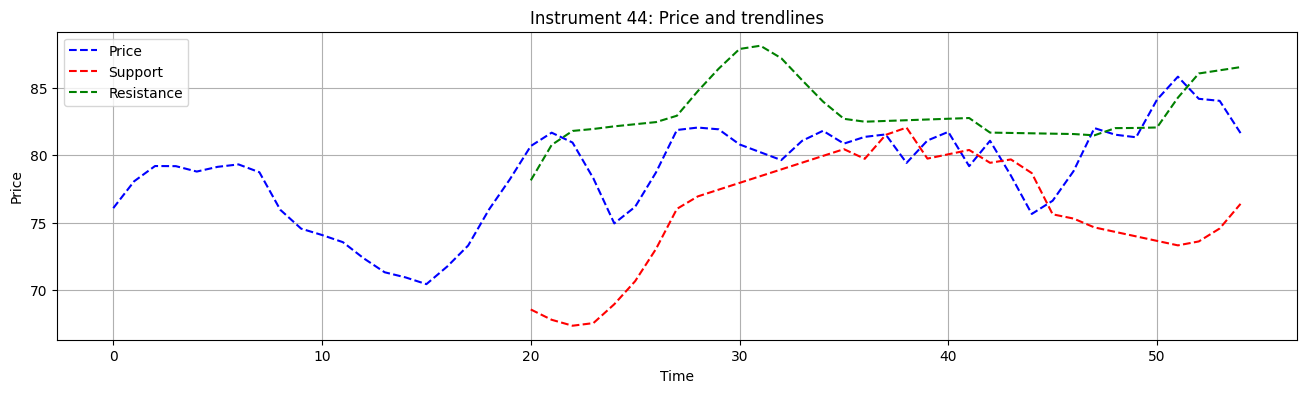

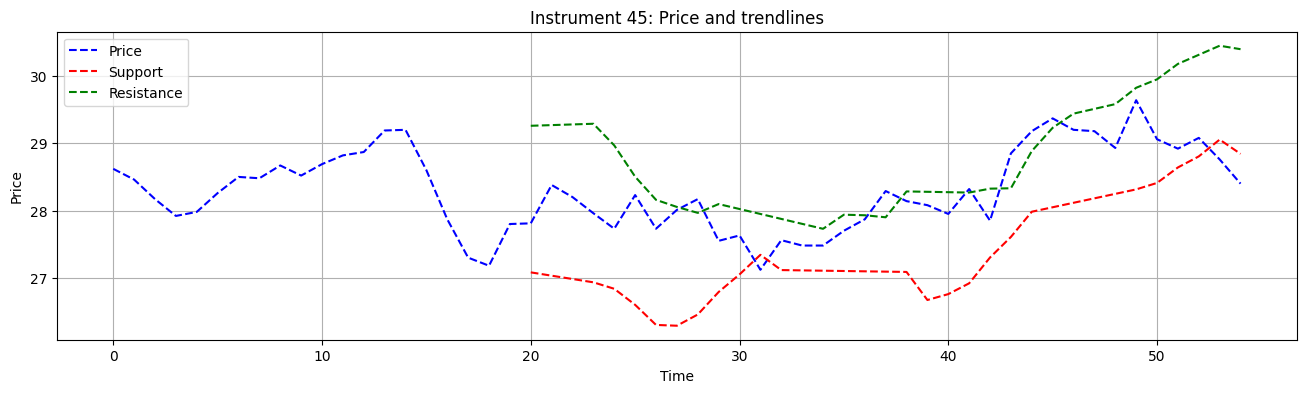

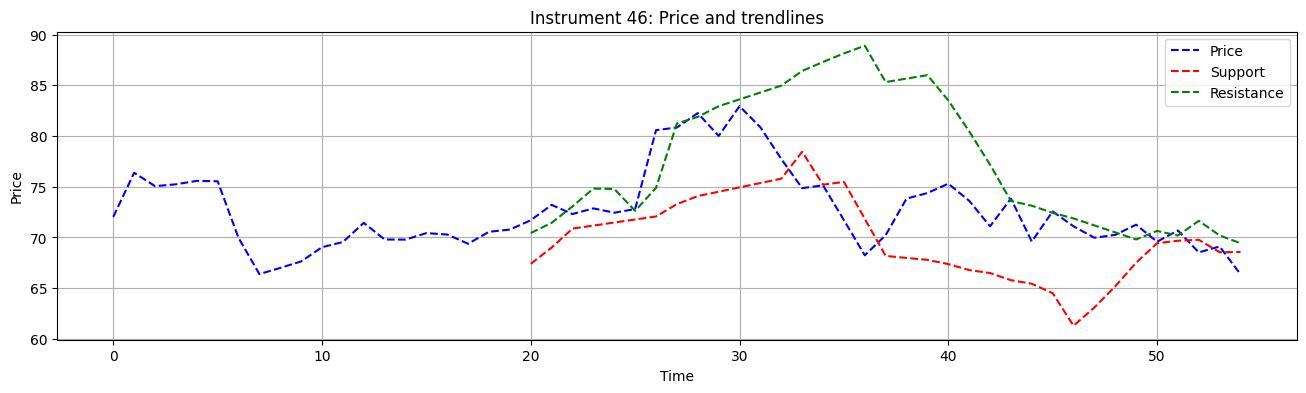

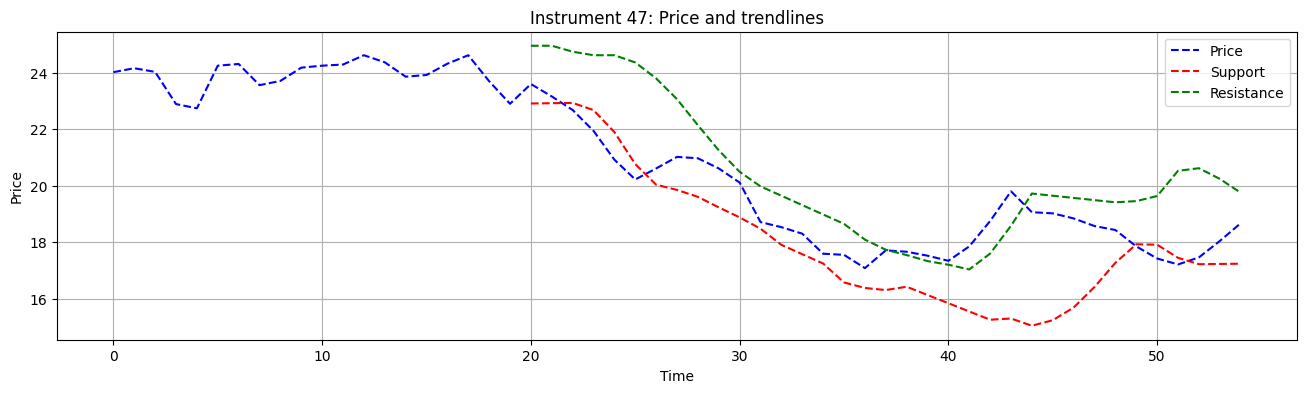

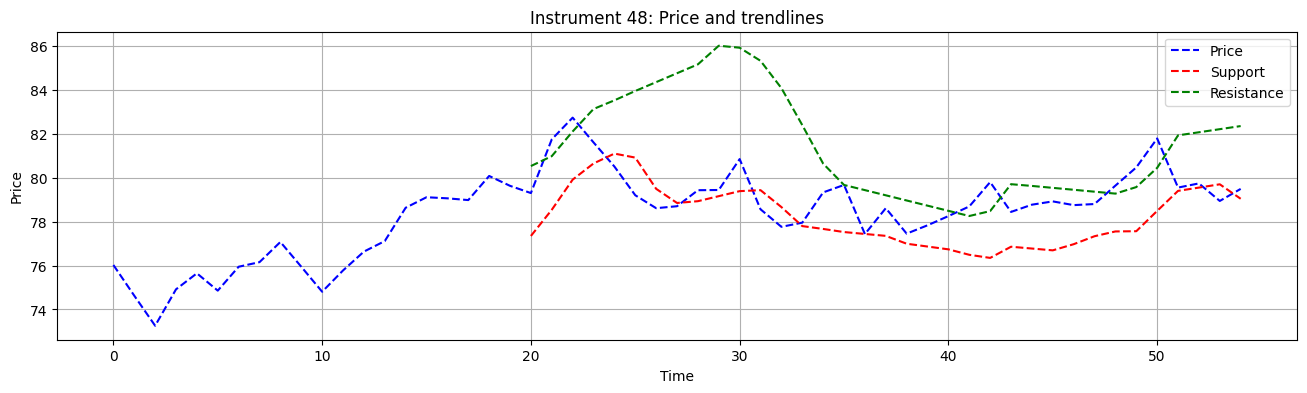

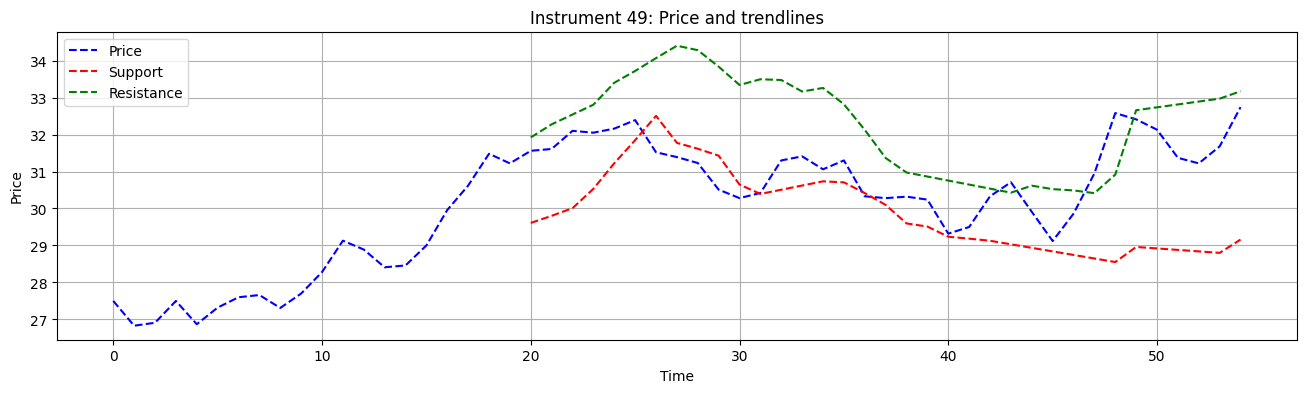

In [78]:
def trendline_breakout(data: Dict[int, DataFrame], lookback: int) -> Dict[int, DataFrame]:
	for instrument_no in data:
		price: ndarray = data[instrument_no]["price"].to_numpy()
		support_trendline = np.zeros(len(price))
		support_trendline[:] = np.nan
		
		resistance_trendline = np.zeros(len(price))
		resistance_trendline[:] = np.nan
		
		signal = np.zeros(len(price))
		
		for i in range(lookback, len(price)):
			window = price[i - lookback: i]
			
			s_coefs, r_coefs = fit_trendlines_single(window)
			
			# Find value of line, projected foward to current bar
			s_val = s_coefs[1] + lookback * s_coefs[0]
			r_val = r_coefs[1] + lookback * r_coefs[0]
			
			support_trendline[i] = s_val
			resistance_trendline[i] = r_val
			
			if price[i] > r_val:
				signal[i] = 1.0
			elif price[i] < s_val:
				signal[i] = -1.0
			else:
				signal[i] = signal[i - 1]
	
		data[instrument_no]["support_trendline"] = support_trendline
		data[instrument_no]["resistance_trendline"] = resistance_trendline
		data[instrument_no]["signal"] = signal
	
	return data

def plot_price_and_trendline():
	data: Dict[int, DataFrame] = get_instruments()
	data = trendline_breakout(data, 20)

	for instrument_no in data:
		price: Series = data[instrument_no]["price"]
		support_trendline = data[instrument_no]["support_trendline"]
		resistance_trendline = data[instrument_no]["resistance_trendline"]
		
		plt.figure(figsize=(16,4))
		plt.plot(price, color="blue", linestyle="--", label="Price")
		plt.plot(support_trendline, color="red", linestyle="--", label="Support")
		plt.plot(resistance_trendline, color="green", linestyle="--", label="Resistance")
		plt.xlabel("Time")
		plt.ylabel("Price")
		plt.title(f"Instrument {instrument_no}: Price and trendlines")
		plt.grid(True)
		plt.legend()
		plt.show()

plot_price_and_trendline()
